In [51]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [52]:
from pathlib import Path

project_root = Path().resolve()
csv_path = project_root / "Data" / "data_information.csv" 
df = pd.read_csv(csv_path)

The data is from a historical marketing campaign in the insurance industry. 
It contains 68 predictive variables. In addition, it contains a treatment (campaign received or not) indicator and a purchase indicator (target).

## Data Preparation ##

In [53]:
print(f"Dimensions: {df.shape[0]:,} rows x {df.shape[1]} columns")
df.head()

Dimensions: 20,000 rows x 70 columns


,treatment,months_since_recent_account_opened,total_high_credit_limit,balance_to_credit_ratio,total_balance_excl_mortgage,num_satisfactory_revolving_accounts,avg_balance_revolving_accounts,num_bank_installment_accounts,months_since_oldest_bank_installment_account_opened,num_financial_installment_accounts,num_satisfactory_installment_accounts,months_since_recent_installment_trade_opened,total_installment_high_credit_limit,months_since_oldest_mortgage_opened,months_since_most_recent_mortgage_update,months_since_recent_mortgage_deal,num_30d_mortgage_delinquencies,num_mortgages_delinquent_last_24m,num_satisfactory_personal_accounts,personal_balance_to_credit_ratio,total_other_financial_credit_limit,num_satisfactory_oil_national_accounts,months_since_oldest_oil_national_trade,num_bankcards_open_last_12m,num_bankcards_open_last_24m,avg_balance_premium_bankcards,num_retail_accounts_open_last_24m,months_since_oldest_retail_account,retail_balance_to_credit_ratio,total_balance_department_store_accounts,num_30d_ratings,num_120d_ratings,num_30d_and_60d_ratings,num_accounts_with_3_missed_in_24m,num_accounts_with_4_missed_in_24m,percent_accounts_never_delinquent,num_accounts_90d_plus_late_last_6m,total_accounts_now_late,num_derogatory_public_records,num_credit_inquiries,num_verified_financial_accounts_last_12m,num_open_revolving_accounts,num_financial_accounts_open_last_12m,highest_retail_credit_limit,num_public_record_derogatory_accounts,months_since_recent_60d_rating,num_disputed_accounts,auto_high_credit_to_actual_ratio,mortgage_1_monthly_payment,mortgage_2_current_balance,premium_bankcard_credit_limit,student_high_credit_range,auto_2_open_date_years_ago,max_mortgage_close_date,upscale_account_open_date_years_ago,student_account_open_date_years_ago,financial_card_open_date_years_ago,age,has_department_card,region_A,region_B,region_C,missing_recent_account_opened,missing_avg_balance_revolving,missing_oldest_bank_installment_account,missing_oldest_mortgage_account,missing_recent_mortgage_deal,missing_personal_balance_to_limit_ratio,purchase,unique_id
0,1,92.000000,24300.0,5.00000,1214.0,0,1767.197203,0.0,99.789583,1.0,0,128.000000,0.0,138.960118,0.664688,25.862878,0.0,0,0,51.730412,0.0,0.0,186.509425,0.0,0,607.000000,0.0,164.2389,11.49123,0.0,0,0,0,0,0,100.000000,0.0,0,0,0,0,2,0,0,0,21.122675,0.0,0,0,0.0,14500.0,0.0,2.33854,3.162295,7.481369,2.474171,1.283733,74.0,0,1,0,0,0,1,1,1,1,1,0,1
1,0,11.000000,798991.0,6.50000,9680.0,0,1767.197203,0.0,99.789583,1.0,1,40.000000,25400.0,185.000000,1.000000,25.862878,0.0,0,1,51.730412,25400.0,0.0,186.509425,0.0,1,624.000000,2.0,157.0000,1.20000,72.0,2,0,2,0,0,90.900000,0.0,0,0,0,2,13,0,2000,0,21.122675,0.0,0,6868,0.0,35000.0,0.0,2.33854,7.622367,4.205479,2.474171,1.283733,31.0,1,0,0,1,0,1,1,0,1,1,1,2
2,0,29.883391,0.0,36.09506,0.0,0,1767.197203,0.0,99.789583,0.0,0,41.790191,0.0,138.960118,0.664688,25.862878,0.0,0,0,51.730412,0.0,0.0,186.509425,0.0,0,2494.414341,0.0,164.2389,11.49123,0.0,0,0,0,0,0,80.814868,0.0,0,0,0,0,0,0,0,1,21.122675,0.0,0,0,0.0,0.0,0.0,2.33854,3.162295,7.481369,2.474171,1.283733,47.0,0,1,0,0,1,1,1,1,1,1,0,3
3,0,29.883391,0.0,36.09506,0.0,0,1767.197203,0.0,99.789583,0.0,0,41.790191,0.0,138.960118,0.664688,25.862878,0.0,0,0,51.730412,0.0,0.0,186.509425,0.0,0,2494.414341,0.0,164.2389,11.49123,0.0,0,0,0,0,0,80.814868,0.0,0,0,0,0,0,0,0,1,21.122675,0.0,0,0,0.0,0.0,0.0,2.33854,3.162295,7.481369,2.474171,1.283733,65.0,0,0,0,1,1,1,1,1,1,1,0,4
4,0,29.883391,0.0,36.09506,0.0,0,1767.197203,0.0,99.789583,0.0,0,41.790191,0.0,138.960118,0.664688,25.862878,0.0,0,0,51.730412,0.0,0.0,186.509425,0.0,0,2494.414341,0.0,164.2389,11.49123,0.0,0,0,0,0,0,80.814868,0.0,0,0,1,0,0,0,0,0,21.122675,0.0,0,0,0.0,0.0,0.0,2.33854,3.162295,7.481369,2.474171,1.283733,24.0,0,1,0,0,1,1,1,1,1,1,0,5


In [54]:
df.drop(columns=["unique_id"], inplace=True)

#### Check treatment and outcome distributions ####
Uplift modeling works best, if we have a balanced 2x2 table of (control vs. treated) x (non-responder vs responder).

In [55]:
print("Treatment Distribution:", df["treatment"].value_counts(dropna=False), "\n")
print("Outcome Distribution:", df["purchase"].value_counts(dropna=False), "\n")

Treatment Distribution: treatment
1    10032
0     9968
Name: count, dtype: int64 

Outcome Distribution: purchase
1    11201
0     8799
Name: count, dtype: int64 



#### Check, if the treatment is independent of the features ####
If the treatment assignment is independent of baseline features, it means that there is no **selection bias**. This way the treatment and control groups are comparable at baseline, eliminating confounding.

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

features_cols = [col for col in df.columns if col not in ["treatment", "purchase", "unique_id"]]

X = df[features_cols]
y = df["treatment"]

X_scaled = StandardScaler().fit_transform(X)

model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_scaled, y)

y_pred =model.predict_proba(X_scaled)[:, 1]

auc = roc_auc_score(y, y_pred)
print(f"AUC: {auc:.4f}")

AUC: 0.5316


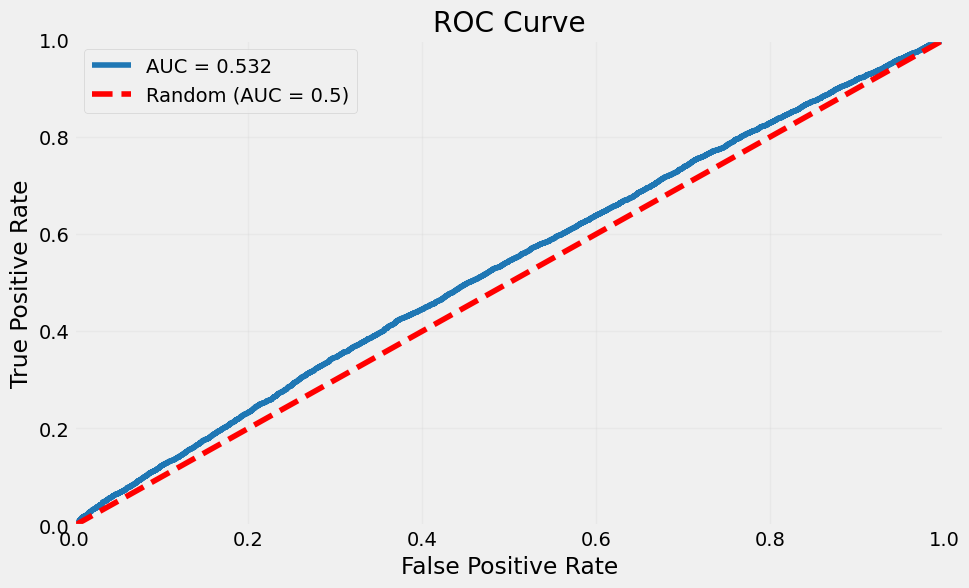

In [57]:
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y, y_pred)
plt.figure(figsize = (10,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", color = "#1f77b4")
plt.plot([0, 1], [0, 1], linestyle='--', color= "red", label = "Random (AUC = 0.5)")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(alpha = 0.2)
plt.show()

#### First Sanity Check ####
Treated customers should not buy less than control. The treated purchase rate should be >= to the control rate to justify running an uplift model.

In [58]:
ct = pd.crosstab(df["treatment"], df["purchase"], normalize = "index")
display(ct.style.format("{:2%}").set_caption("Outcome rate by treatment flag"))

purchase,0,1
treatment,,
0,44.321830%,55.678170%
1,43.670255%,56.329745%


#### Checking for NA values ####

In [59]:
df.isna().values.any()

np.False_

#### Train - Test Split ####
We need an out-of-sample benchmark that can fairly compare uplift models.
To achieve this, we need to make sure that we stratify on both Treatment x Outcome.

Ordinary **train_test_split(stratify = y)** only balances the outcome, but Uplift learning also needs the treatment balanced, otherwise the test set might contain mostly treated customers even though the training set is balanced.  
That is why we create a joint stratum label, thus every combination is proportionally represented in train and test set.

In [60]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ["purchase"])
y = df["purchase"]

strata = df["treatment"].astype(str) + "_" + y.astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.5,
    stratify = strata,
    random_state = 42
)

## Uplift Models ##

### Two-Model Approach ###
The two model approach trains two separate predictive models to estimate uplift:

1. Treatment Model
- Trained only on customers who received the treatment (campaign)
- Thus, prediciting the purchase probability **under treatment** $P(Y=1\mid X)^{M_T}$

2. Control Model
- Trained only on customers who did not receive the treatment (campaign)
- Thus, prediciting the purchase probability **without treatment**: $P(Y=1\mid X)^{M_C}$

Putting these two together, we estimate Uplift:
$$\tau(X) = P(Y=1\mid X)^{M_T} - P(Y=1\mid X)^{M_C}$$

#### Create treatment and control groups for training data ####

In [61]:
np.random.seed(42)

mask_treated_train = X_train["treatment"] == 1
mask_control_train = X_train["treatment"] == 0

X_train_treated = X_train.loc[mask_treated_train].drop(columns=["treatment"])
X_train_control = X_train.loc[mask_control_train].drop(columns=["treatment"])

y_train_treated = y_train.loc[mask_treated_train]
y_train_control = y_train.loc[mask_control_train]

#### Train & fit XGBoost models for treated and control groups ####

In [62]:
from xgboost import XGBClassifier

model_treated = XGBClassifier(
    eval_metric = "logloss",
    random_state = 42,
    n_estimators = 100,
    max_depth = 6,
    learning_rate = 0.3
)

model_control = XGBClassifier(
    eval_metric = "logloss",
    random_state = 42,
    n_estimators = 100,
    max_depth = 6,
    learning_rate = 0.3
)

# Treated #
model_treated.fit(X_train_treated, y_train_treated)
# Control #
model_control.fit(X_train_control, y_train_control)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

#### Prepare test data for prediction (we need the test data without treatment columns too) ####

In [63]:
X_test_features = X_test.drop(columns=["treatment"])
test_treatments = X_test["treatment"]

#### Generate Uplift predictions ####

In [64]:
# Generate probability predictions from both models #
prob_treated = model_treated.predict_proba(X_test_features)[:, 1]
prob_control = model_control.predict_proba(X_test_features)[:, 1]

# Generate uplift predictions #
uplift_predictions_two = prob_treated - prob_control

#### Plot Uplift Distribution ####

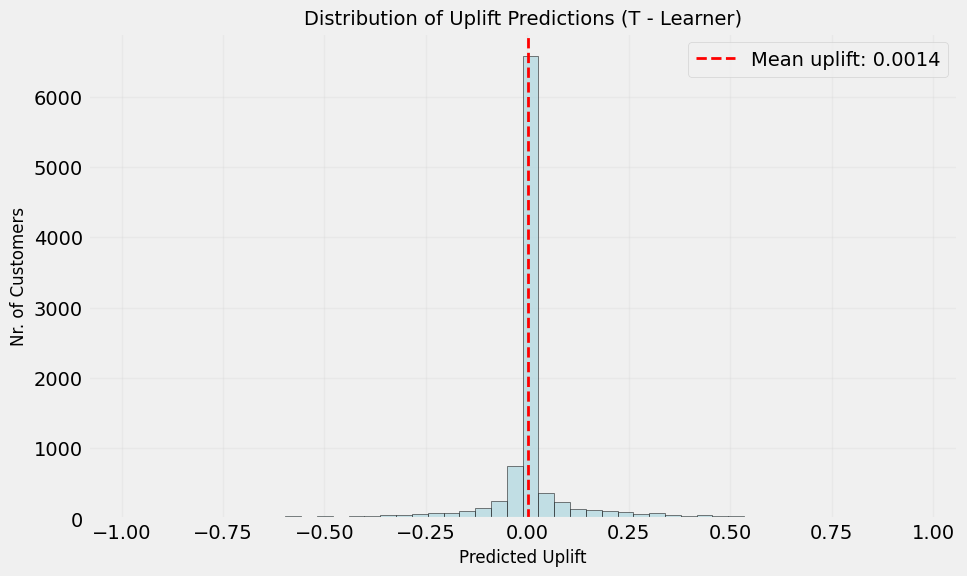

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 6))
plt.hist(uplift_predictions_two, bins = 50, alpha = 0.7, color = '#AED7E0', edgecolor = 'black')

plt.axvline(x = uplift_predictions_two.mean(), color = 'red', linestyle = '--', 
            linewidth = 2, label = f'Mean uplift: {uplift_predictions_two.mean():.4f}')

plt.xlabel('Predicted Uplift', fontsize = 12)
plt.ylabel('Nr. of Customers', fontsize = 12)
plt.title('Distribution of Uplift Predictions (T - Learner)', fontsize = 14)
plt.grid(alpha = 0.2)
plt.legend()
plt.show()

#### Results Dataframe ####

In [66]:
results_df = pd.DataFrame({
    'model_score': uplift_predictions_two,
    'w': test_treatments.values,
    'y': y_test.values
})

#### Plotting Uplift-Chart ####

In [67]:
from deciles_function import uplift_by_decile

decile_df = uplift_by_decile(
    results_df,
    treat_col = "w",
    outcome_col = "y",
    uplift_col = "model_score",
)
decile_df

,decile,n_customers,avg_predicted_uplift,actual_uplift,treated_purchase_rate,control_purchase_rate
0,0,1000,0.315146,0.098000,0.388000,0.290000
1,1,1000,0.037306,-0.000536,0.168724,0.169261
2,2,1000,0.001388,-0.008863,0.546693,0.555556
3,3,1000,0.000091,-0.006193,0.964083,0.970276
4,4,1000,0.000033,0.001325,0.987680,0.986355
5,5,1000,-0.000002,-0.010076,0.975952,0.986028
6,6,1000,-0.000165,0.002000,0.904000,0.902000
7,7,1000,-0.003080,0.009241,0.266667,0.257426
8,8,1000,-0.029230,0.008351,0.105058,0.096708
9,9,1000,-0.307455,-0.061136,0.308943,0.370079


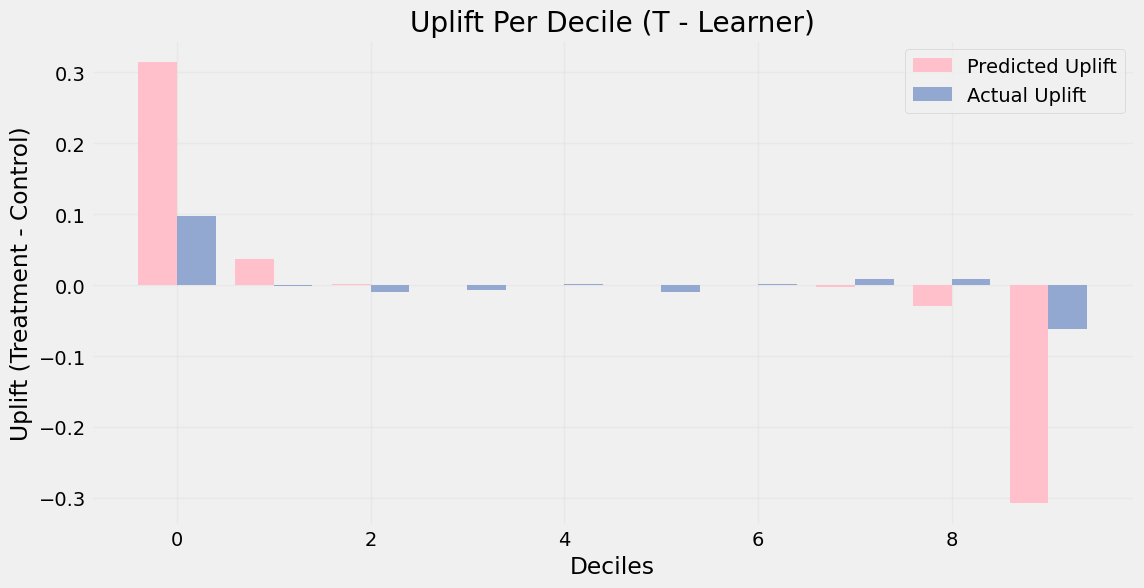

In [68]:
plt.figure(figsize = (12, 6))

deciles = np.arange(len(decile_df))
pred = decile_df['avg_predicted_uplift']
act  = decile_df['actual_uplift']

plt.bar(deciles - 0.2, pred, width = 0.4, label = 'Predicted Uplift', color = "pink")
plt.bar(deciles + 0.2, act,  width = 0.4, label = 'Actual Uplift', color = "#92A8D1")


plt.xlabel('Deciles')
plt.ylabel('Uplift (Treatment - Control)')
plt.title('Uplift Per Decile (T - Learner)')
plt.grid(alpha = 0.2)
plt.legend()

plt.show()


### Qini-Curve ###

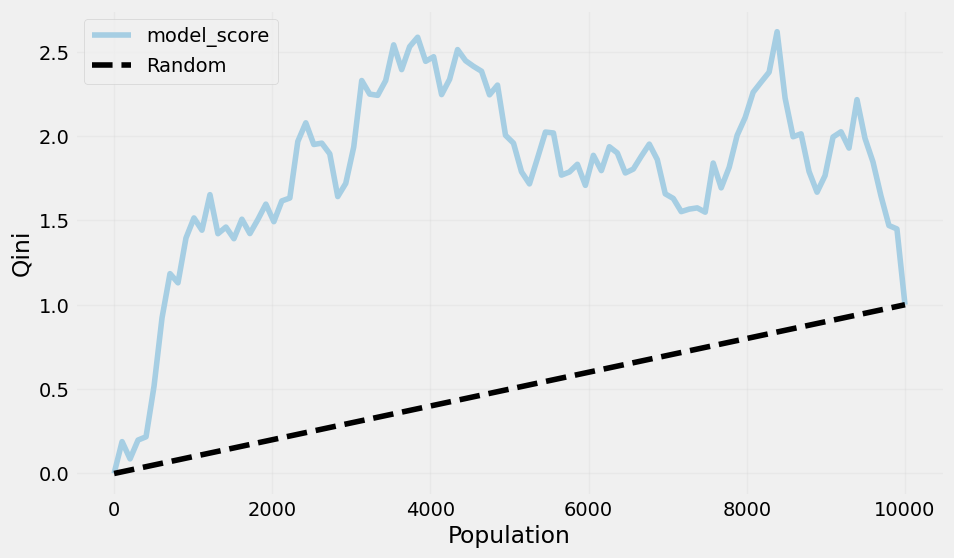

In [ ]:
from causalml.metrics import plot_qini
plot_qini(results_df, normalize = True, figsize = (10, 6))
plt.grid(alpha = 0.2)

### Class Transformation Method ###
This method was introduced by *[Jaskowski and Jaroszewicz (2012)](https://people.cs.pitt.edu/~milos/icml_clinicaldata_2012/Papers/Oral_Jaroszewitz_ICML_Clinical_2012.pdf)*.
It creates the following target variable:
$$Z_i= Y_i^{obs} W_i + (1-Y_i^{obs})(1-W_i)$$
so
$$
Z_i = 
\begin{cases}
    1 & \text{if } W_i = T \text{ and } Y_i = 1 \\
    1 & \text{if } W_i = C \text{ and } Y_i = 0 \\
    0 & \text{otherwise}
\end{cases}
$$
with $W_i$ being the treatment indicator.

Under the assumption that control and treated groups are balanced across all profiles of individual (meaning $p(X_i = x) = 1/2\quad \forall x$) it can be proven that (see *[Jaskowski and Jaroszewicz (2012)](https://people.cs.pitt.edu/~milos/icml_clinicaldata_2012/Papers/Oral_Jaroszewitz_ICML_Clinical_2012.pdf)*):
$$\tau(X_i) = 2P(Z_i = 1\mid X_i) - 1$$

Thus, to model uplift one just needs to estimate $P(Z_i = 1\mid X_i)$, for which any classifier can be used.

#### Create Target Variable ####

In [70]:
X_train_combined = X_train.copy()

Z_train = ((X_train_combined["treatment"] == 1) & (y_train == 1)) | \
    ((X_train_combined["treatment"] == 0) & (y_train == 0))
    
Z_train = Z_train.astype(int)


#### Checking treatment distribution again ####
As above, the treatment/ control distribution is very balanced. Thus, no sample weights are necessary.

In [71]:
treatment_dist = X_train["treatment"].value_counts(normalize=True)
print(f"Treatment Distribution:{treatment_dist}")

Treatment Distribution:treatment
1    0.5016
0    0.4984
Name: proportion, dtype: float64


#### Train & fit the model ####

In [72]:
X_train_features = X_train_combined.drop(columns=["treatment"])

model_transform = XGBClassifier(
    eval_metric = "logloss",
    random_state = 42,
    n_estimators = 100,
    max_depth = 6,
    learning_rate = 0.3
)

model_transform.fit(X_train_features, Z_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

#### Generate Uplift Predictions ####

In [73]:
X_test_features = X_test.drop(columns=["treatment"])

prob_z_one = model_transform.predict_proba(X_test_features)[:, 1]

uplift_predictions_trans = 2 * prob_z_one - 1

#### Plot Uplift Distributions ####

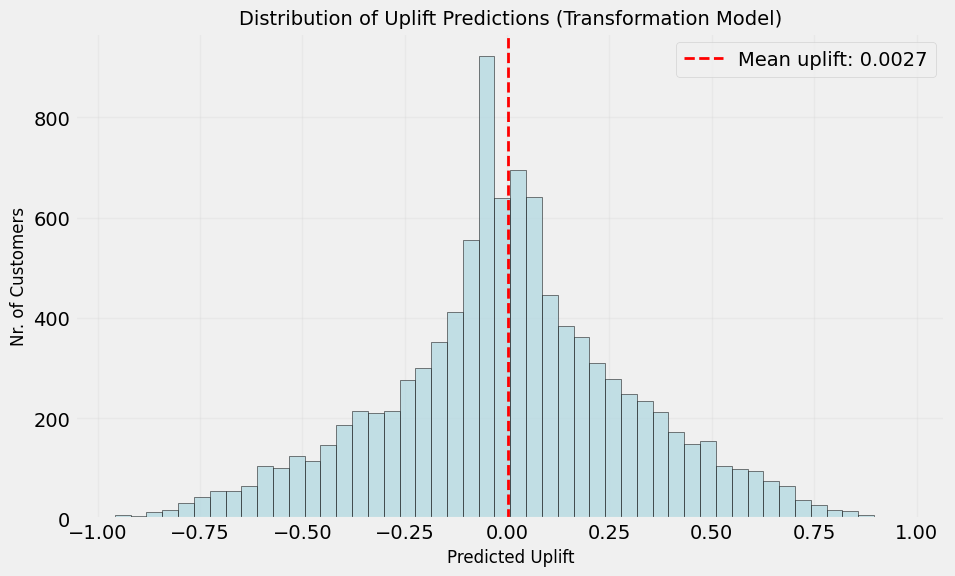

In [74]:
plt.figure(figsize=(10, 6))

plt.hist(uplift_predictions_trans, bins = 50, alpha = 0.7, color = "#AED7E0", edgecolor = "black")

plt.axvline(x = uplift_predictions_trans.mean(), color = "red", linestyle = "--", 
            linewidth = 2, label = f"Mean uplift: {uplift_predictions_trans.mean():.4f}")

plt.xlabel("Predicted Uplift", fontsize = 12)
plt.ylabel("Nr. of Customers", fontsize = 12)
plt.title("Distribution of Uplift Predictions (Transformation Model)", fontsize = 14)
plt.grid(alpha = 0.2)
plt.legend()
plt.show()

#### Results Dataframe ####

In [75]:
results_trans = pd.DataFrame({
    'model_score': uplift_predictions_trans,
    'w': X_test['treatment'].values,
    'y': y_test.values
})
results_trans

,model_score,w,y
0,0.098034,1,0
1,0.231480,1,0
2,0.326668,1,0
3,0.098645,0,1
4,-0.053510,1,0
...,...,...,...
9995,0.006537,0,1
9996,-0.037219,1,1
9997,-0.536830,1,1
9998,-0.204800,0,1


#### Plotting Uplift-Chart ####

In [76]:
from deciles_function import uplift_by_decile
decile_df_trans = uplift_by_decile(
    results_trans,
    uplift_col = "model_score",
    treat_col = "w",
    outcome_col = "y"
)
decile_df_trans

,decile,n_customers,avg_predicted_uplift,actual_uplift,treated_purchase_rate,control_purchase_rate
0,0,1000,0.550629,-0.004026,0.544031,0.548057
1,1,1000,0.313352,0.008543,0.519348,0.510806
2,2,1000,0.181143,0.033113,0.590457,0.557344
3,3,1000,0.086843,-0.003381,0.663286,0.666667
4,4,1000,0.026245,-0.000192,0.636905,0.637097
5,5,1000,-0.029741,0.084561,0.490872,0.406312
6,6,1000,-0.078405,-0.009328,0.439364,0.448692
7,7,1000,-0.162765,-0.017206,0.563707,0.580913
8,8,1000,-0.302407,-0.002328,0.580838,0.583166
9,9,1000,-0.558010,-0.027532,0.603206,0.630739


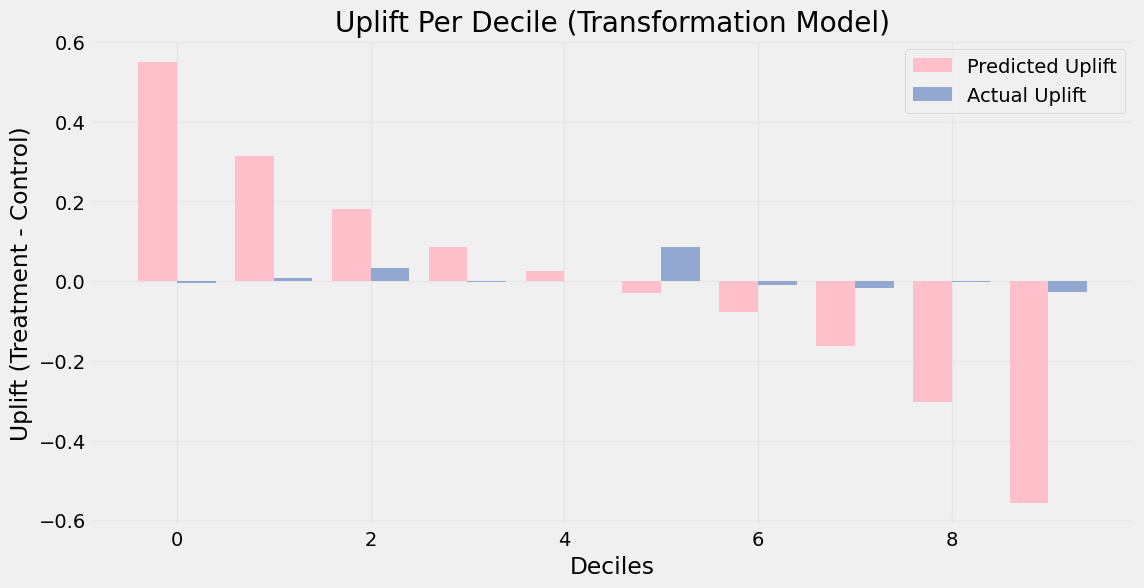

In [77]:
plt.figure(figsize = (12, 6))

deciles = np.arange(len(decile_df_trans))
pred = decile_df_trans['avg_predicted_uplift']
act  = decile_df_trans['actual_uplift']

plt.bar(deciles - 0.2, pred, width = 0.4, label = 'Predicted Uplift', color = "pink")
plt.bar(deciles + 0.2, act,  width = 0.4, label = 'Actual Uplift', color = "#92A8D1")


plt.xlabel('Deciles')
plt.ylabel('Uplift (Treatment - Control)')
plt.title("Uplift Per Decile (Transformation Model)")
plt.grid(alpha = 0.2)
plt.legend()

plt.show()

### Qini-Curve ###

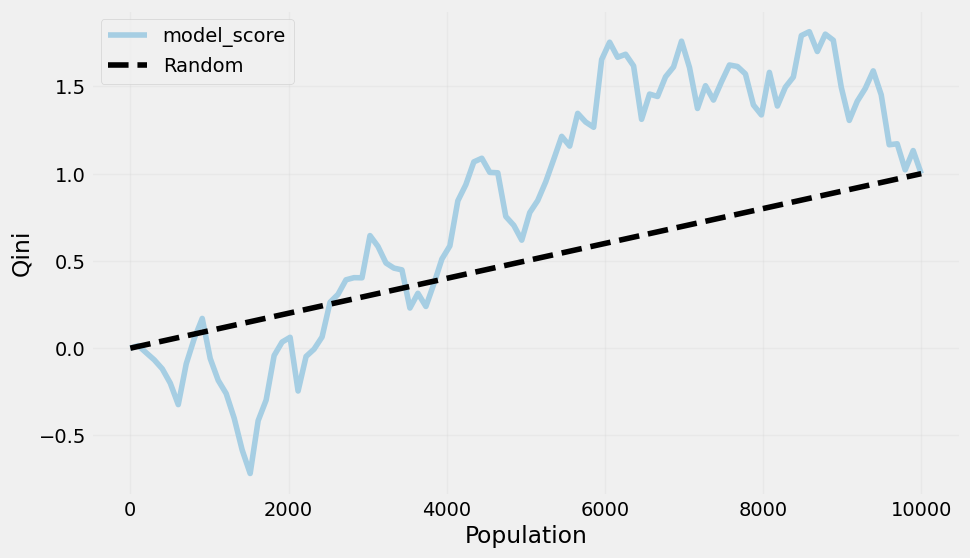

In [78]:
plot_qini(results_trans, figsize = (10, 6), normalize = True)
plt.grid(alpha = 0.2)

### Modeling Uplift Directly ###
This approach consists of modifying existing machine learning algorithms to directly calculate a treatment effect. In the literature the most popular methods are the tree based ones.  
Thus, in the following we will focus on these and their principal task: **the split criterion choice**.  
Note, if the randomized experiment is balanced (which ours is) then the estimator of the average treatment effect is given by:
$$
\hat{\tau} =
\underbrace{
  \frac{\sum_i Y_i^{obs} W_i}{\sum_i W_i}
}_{p}
-
\underbrace{
  \frac{\sum_i Y_i^{obs} (1 - W_i)}{\sum_i (1 - W_i)}
}_{q}
$$

Thus, p and q being the average outcome in the treatment and control group respectively.

There are different split criteria in the literature for building uplift trees. These criteria determine how the tree decides where to split the data to best separate people with different treatment effects. An example is the **difference of uplift between the two leaves** proposed by *[Hansotia and Rukstales (2002)](https://www.sciencedirect.com/sdfe/pdf/download/eid/1-s2.0-S1094996802701618/first-page-pdf)*.  
In our example we will focus on the information theory-based approach by *[Rzepakowski and Jaroszewicz (2012)](https://link.springer.com/article/10.1007/s10115-011-0434-0)*.

Their proposed split criterion maximizes the gain in divergence following a split. The idea is to find splits that maximize the difference in treatment & control outcome distributions:
$$\Delta_{gain} = D_{after\_split}(P^T, P^C)-D_{before\_split}(P^T, P^C)$$
with $D(\cdot)$ being a divergence measure, $P^T$ the probability distribution of the outcome in the treated group and $P^C$ in the control group.

The authors then proposed three divergence metrics: Kullback-Leibler, Euclidean and Chi-squared - from which we chose the Kullback-Leibler for our model:
$$KL(P:Q) = \sum_{k=Left,Right}p_k log \frac{p_k}{q_k}$$

with subscript k indicating in which leaf we compute $p$ and $q$, which we defined above.  
This can be easily implemented using prebuild functions from the *[CausalML](https://causalml.readthedocs.io/en/latest/about.html)* package.

#### Preparing the data ####
The package expects our treatment to be a string, so we create a treatment array with string labels:

In [79]:
X_train_features = X_train.drop(columns = ["treatment"]).values
X_test_features = X_test.drop(columns = ["treatment"]).values

treatment_train = np.where(X_train["treatment"].values == 1, "treatment", "control")
treatment_test = np.where(X_test["treatment"].values == 1, "treatment", "control")
y_train_array = y_train.values
y_test_array = y_test.values

#### Train & Fit Uplift Tree ####

In [80]:
from causalml.inference.tree import UpliftTreeClassifier

uplift_tree = UpliftTreeClassifier(
    max_depth = 5,
    min_samples_leaf = 100,
    min_samples_treatment = 50,
    n_reg = 100,
    evaluationFunction = "KL",
    control_name = "control"
    )

uplift_tree.fit(
    X = X_train_features,
    treatment = treatment_train,
    y = y_train_array)

#### Train & Fit Uplift Random Forest (Ensemble Direct Method) ####

In [81]:
from causalml.inference.tree import UpliftRandomForestClassifier

uplift_rf = UpliftRandomForestClassifier(
    n_estimators = 100,
    max_depth = 5,
    min_samples_leaf = 100,
    min_samples_treatment = 50,
    n_reg = 100,
    evaluationFunction = "KL",
    control_name = "control",
    random_state = 42
)

uplift_rf.fit(
    X = X_train_features,
    treatment = treatment_train,
    y = y_train_array
)

#### Generate Predictions ####

In [82]:
tree_uplift_pred_comp = uplift_tree.predict(X_test_features)
tree_uplift_pred = tree_uplift_pred_comp[:, 1] - tree_uplift_pred_comp[:, 0]

rf_uplift_pred = uplift_rf.predict(X_test_features)

#### Plot Uplift Distributions ####

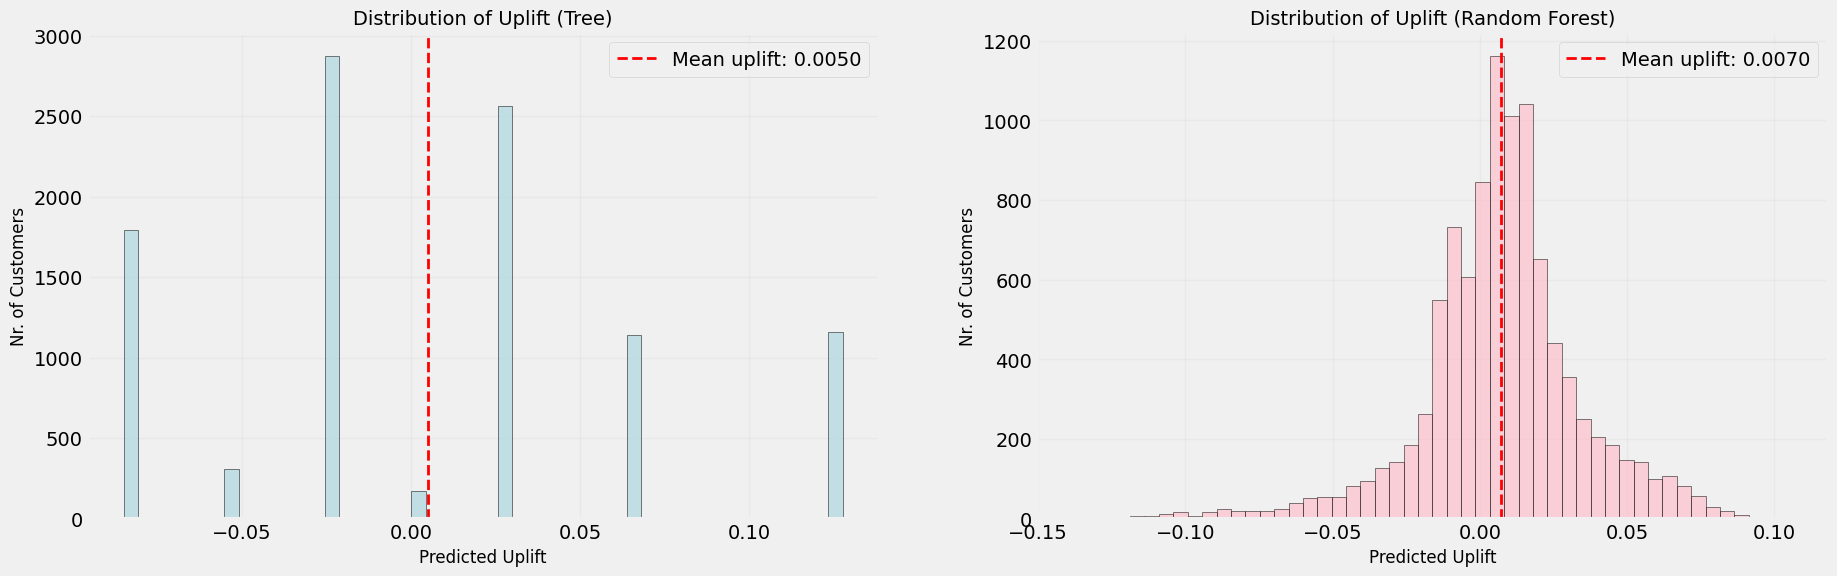

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 6))

# Uplift Distribution - Tree 
ax1.hist(tree_uplift_pred, bins = 50, alpha = 0.7, color = "#AED7E0", edgecolor = "black")
ax1.axvline(x = tree_uplift_pred.mean(), color = "red", linestyle = "--", 
            linewidth = 2, label = f"Mean uplift: {tree_uplift_pred.mean():.4f}")
ax1.set_xlabel("Predicted Uplift", fontsize = 12)
ax1.set_ylabel("Nr. of Customers", fontsize = 12)
ax1.set_title("Distribution of Uplift (Tree)", fontsize = 14)
ax1.grid(alpha = 0.2)
ax1.legend()

# Uplift Distribution - Random Forest 
ax2.hist(rf_uplift_pred, bins = 50, alpha = 0.7, color = "pink", edgecolor = "black")
ax2.axvline(x = rf_uplift_pred.mean(), color = "red", linestyle = "--", 
            linewidth = 2, label = f"Mean uplift: {rf_uplift_pred.mean():.4f}")
ax2.set_xlabel("Predicted Uplift", fontsize = 12)
ax2.set_ylabel("Nr. of Customers", fontsize = 12)
ax2.set_title("Distribution of Uplift (Random Forest)", fontsize = 14)
ax2.grid(alpha = 0.2)
ax2.legend()

plt.show()

In [84]:
results_direct_tree = pd.DataFrame({
    "model_score": tree_uplift_pred.flatten(),
    "w": X_test["treatment"].values,
    "y": y_test_array
})

In [85]:
results_direct_rf = pd.DataFrame({
    "model_score": rf_uplift_pred.squeeze(),
    "w": X_test["treatment"].values,
    "y": y_test_array
})

#### Plot Uplift Charts ####

In [86]:
decile_df_tree = uplift_by_decile(
    results_direct_tree,
    uplift_col = "model_score",
    treat_col = "w",
    outcome_col = "y"
)
decile_df_tree

,decile,n_customers,avg_predicted_uplift,actual_uplift,treated_purchase_rate,control_purchase_rate
0,0,1000,0.124868,0.050195,0.371901,0.321705
1,1,1000,0.074453,-0.029004,0.736527,0.765531
2,2,1000,0.039454,0.000464,0.923228,0.922764
3,3,1000,0.027519,0.064018,0.698969,0.634951
4,4,1000,0.022985,-0.010105,0.323887,0.333992
5,5,1000,-0.024584,0.058976,0.581952,0.522976
6,6,1000,-0.025372,-0.042475,0.517442,0.559917
7,7,1000,-0.028047,-0.001616,0.595190,0.596806
8,8,1000,-0.077068,-0.054080,0.493014,0.547094
9,9,1000,-0.083997,-0.005445,0.373196,0.378641


In [87]:
decile_df_rf = uplift_by_decile(
    results_direct_rf,
    uplift_col = "model_score",
    treat_col = "w",
    outcome_col = "y"
)
decile_df_rf

,decile,n_customers,avg_predicted_uplift,actual_uplift,treated_purchase_rate,control_purchase_rate
0,0,1000,0.056177,0.077831,0.334694,0.256863
1,1,1000,0.030843,0.035094,0.342495,0.307400
2,2,1000,0.020027,0.033854,0.663265,0.629412
3,3,1000,0.014686,-0.010530,0.722672,0.733202
4,4,1000,0.009793,0.047727,0.757339,0.709611
5,5,1000,0.005550,0.017016,0.695896,0.678879
6,6,1000,0.000621,-0.030803,0.724752,0.755556
7,7,1000,-0.006524,-0.004433,0.515810,0.520243
8,8,1000,-0.014543,-0.047935,0.386847,0.434783
9,9,1000,-0.046279,-0.101607,0.465587,0.567194


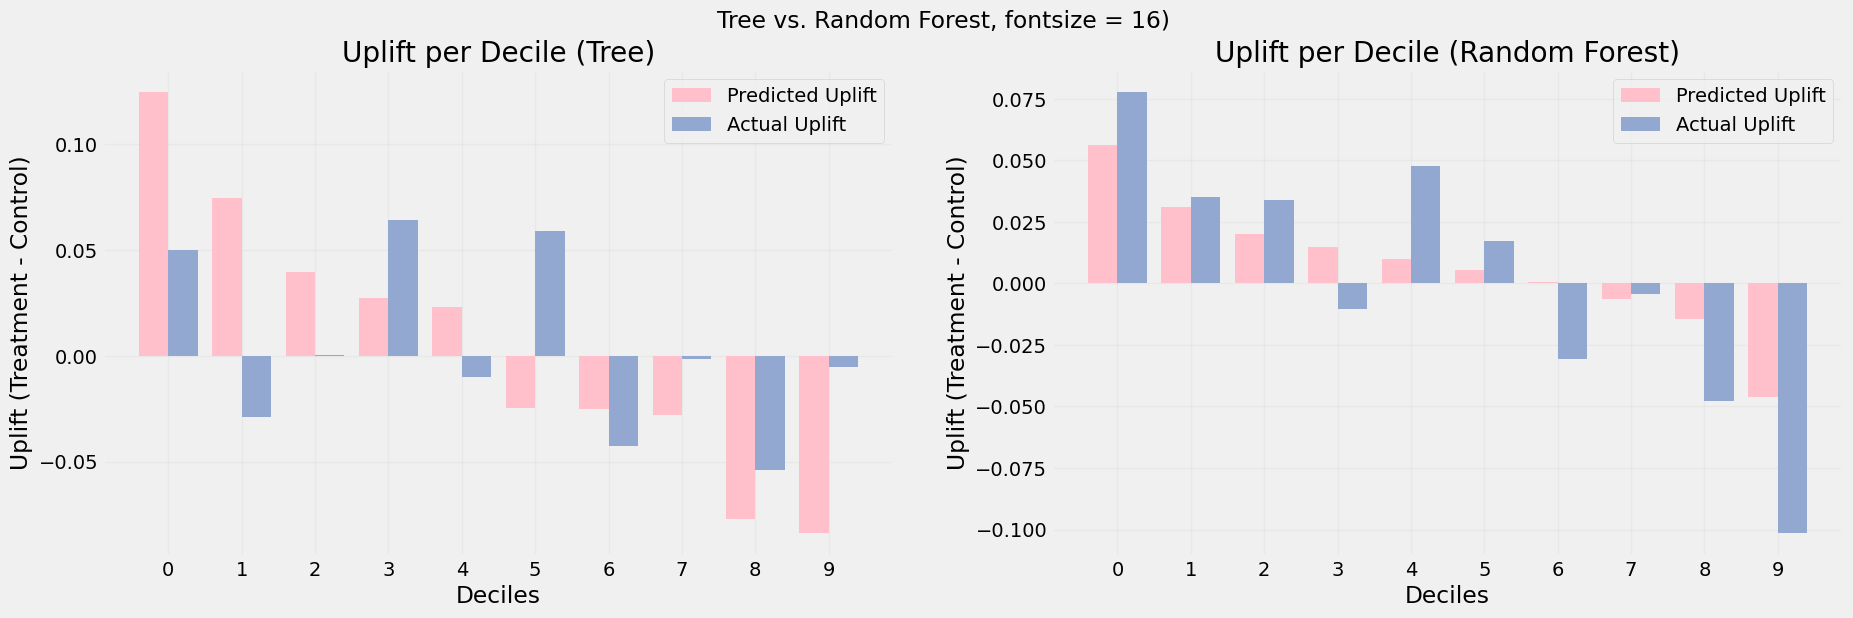

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 6))

# Uplift-Chart - Tree
deciles_tree = np.arange(len(decile_df_tree))
pred_tree = decile_df_tree["avg_predicted_uplift"]
actual_tree = decile_df_tree["actual_uplift"]

ax1.bar(deciles_tree - 0.2, pred_tree, width = 0.4, label = "Predicted Uplift", color = "pink")
ax1.bar(deciles_tree + 0.2, actual_tree, width = 0.4, label = "Actual Uplift", color = "#92A8D1")
ax1.set_xlabel("Deciles")
ax1.set_ylabel("Uplift (Treatment - Control)")
ax1.set_title("Uplift per Decile (Tree)")
ax1.set_xticks(deciles_tree)
ax1.grid(alpha = 0.2)
ax1.legend()

# Uplift-Chart - Random Forest
deciles_rf = np.arange(len(decile_df_rf))
pred_rf = decile_df_rf["avg_predicted_uplift"]
actual_rf = decile_df_rf["actual_uplift"]

ax2.bar(deciles_rf - 0.2, pred_rf, width = 0.4, label = "Predicted Uplift", color = "pink")
ax2.bar(deciles_rf + 0.2, actual_rf, width = 0.4, label = "Actual Uplift", color = "#92A8D1")
ax2.set_xlabel("Deciles")
ax2.set_ylabel("Uplift (Treatment - Control)")
ax2.set_title("Uplift per Decile (Random Forest)")
ax2.set_xticks(deciles_rf)
ax2.grid(alpha = 0.2)
ax2.legend()

fig.suptitle("Tree vs. Random Forest, fontsize = 16)")
plt.show()

### Qini-Curves ###

#### Qini-Curve Decision Tree ####

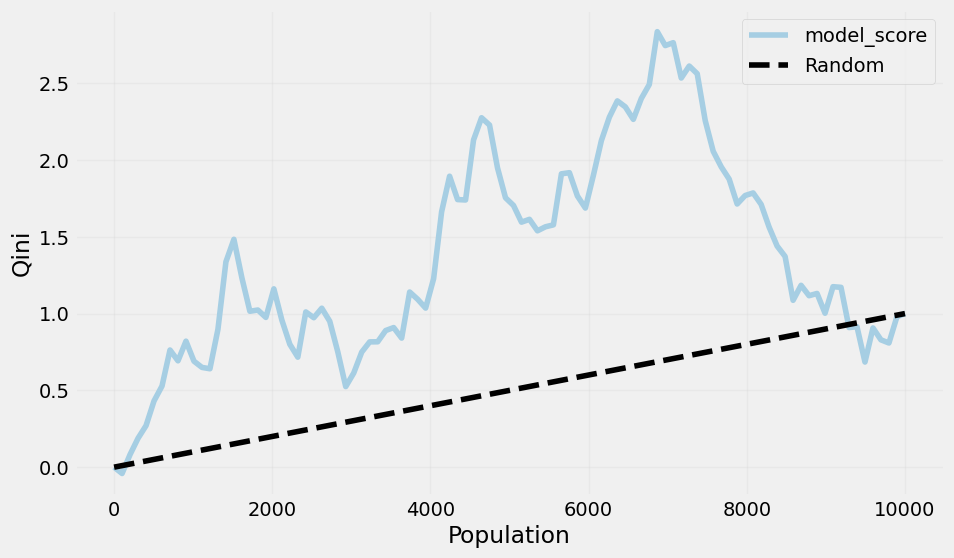

In [92]:
plot_qini(results_direct_tree, normalize = True, figsize = (10, 6))
plt.grid(alpha = 0.2)

#### Qini-Curve Random Forest ####

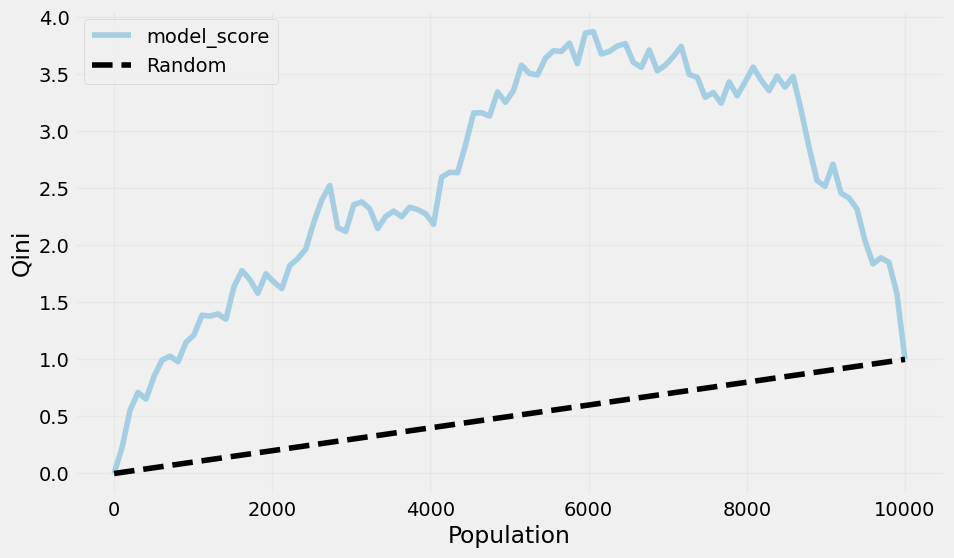

In [90]:
plot_qini(results_direct_rf, normalize = True, figsize = (10, 6))
plt.grid(alpha = 0.2)